In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import numpy as np
import os
import json

In [1]:
# Find the normalisation parameters 

import pandas as pd
import numpy as np
import os
import json

# --- Configuration ---
DATA_FOLDER = 'Cantera_Dataset' # Or '/content/drive/MyDrive/SciML_Project_Data'

# Get a list of all data files
try:
    all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')]
    if not all_files:
        raise FileNotFoundError
except FileNotFoundError:
    print(f"Error: No CSV files found in '{DATA_FOLDER}'.")
    print("Please check the path or make sure you ran Phase 1.")
    raise

print(f"Found {len(all_files)} files. Starting analysis...")

# Initialize dictionaries to hold the global min/max values
# We start with infinity so the first file's values will always be smaller/larger
global_mins = {}
global_maxs = {}

# We need the column names. We'll get them from the first file.
first_file_path = os.path.join(DATA_FOLDER, all_files[0])
df_first = pd.read_csv(first_file_path)
columns_to_process = df_first.columns.drop('Time (s)') # We don't normalize time

# Initialize the dictionaries
for col in columns_to_process:
    global_mins[col] = np.inf
    global_maxs[col] = -np.inf

# --- Loop over all files to find global min/max ---
for i, filename in enumerate(all_files):
    file_path = os.path.join(DATA_FOLDER, filename)
    df = pd.read_csv(file_path)
    
    # Update global min/max for each column
    for col in columns_to_process:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min < global_mins[col]:
            global_mins[col] = col_min
        
        if col_max > global_maxs[col]:
            global_maxs[col] = col_max
            
    if (i+1) % 20 == 0: # Print progress
        print(f"Processed {i+1}/{len(all_files)} files...")

# --- Save the results ---
normalization_params = {
    'mins': global_mins,
    'maxs': global_maxs
}

save_filename = 'normalization_params.json'
with open(save_filename, 'w') as f:
    json.dump(normalization_params, f, indent=4)

print("\n--- Global Normalization Parameters ---")
print(f"Saved to {save_filename}")
# Optional: Print a few values
print(f"Global Temp Min: {global_mins['Temperature (K)']:.2f} K")
print(f"Global Temp Max: {global_maxs['Temperature (K)']:.2f} K")
print(f"Global NH3 Min: {global_mins['NH3']:.2e}")
print(f"Global NH3 Max: {global_maxs['NH3']:.2e}")

Found 100 files. Starting analysis...
Processed 20/100 files...
Processed 40/100 files...
Processed 60/100 files...
Processed 80/100 files...
Processed 100/100 files...

--- Global Normalization Parameters ---
Saved to normalization_params.json
Global Temp Min: 1199.97 K
Global Temp Max: 2736.56 K
Global NH3 Min: 5.00e-10
Global NH3 Max: 1.88e-01


In [4]:
# Normalize and Sample Trajectories

# Procedure used:
# 1. Load each CSV file again.
# 2. Normalize its data to the [0, 1] range.
# 3. Strategically sample 50 points, just like the Bansude paper, by finding the ignition delay and taking log-spaced points before and after it.
# 4. Save all these sampled, normalized trajectories into one big .npz file, which is perfect for loading in PyTorch/TensorFlow.


# --- Configuration ---
DATA_FOLDER = 'Cantera_Dataset' # Or '/content/drive/MyDrive/SciML_Project_Data'
PARAMS_FILE = 'normalization_params.json'
N_SAMPLES_PER_CURVE = 50 # Total samples to keep from each curve
SIM_END_TIME = 0.30     
OUTPUT_FILE = 'training_data.npz' # Final compressed training data

# --- 1. Load Normalization Params ---
try:
    with open(PARAMS_FILE, 'r') as f:
        norm_params = json.load(f)
    mins = norm_params['mins']
    maxs = norm_params['maxs']
except FileNotFoundError:
    print(f"Error: '{PARAMS_FILE}' not found. Did you run Step 2a?")
    raise

columns_to_normalize = list(mins.keys())

# --- 2. Create the Standard Time Base ---
# We will interpolate all simulations onto these 50 time points.
# We use np.geomspace (log-space) as it's better for ignition.
# Start at a small value (not 0) for log-space, e.g., 1e-6 seconds.
standard_time_points = np.geomspace(1e-6, SIM_END_TIME, N_SAMPLES_PER_CURVE)

# --- Lists to store all processed data ---
# This list will hold arrays of shape (50, n_features)
all_interpolated_trajectories = [] 

# --- Get all data files ---
try:
    all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')]
    if not all_files:
        raise FileNotFoundError
except FileNotFoundError:
    print(f"Error: Data folder '{DATA_FOLDER}' not found.")
    raise
    
print(f"Found {len(all_files)} files. Starting pre-processing...")

# --- Loop over all files ---
for i, filename in enumerate(all_files):
    file_path = os.path.join(DATA_FOLDER, filename)
    df = pd.read_csv(file_path)

    # --- 3. Normalize the Data ---
    df_normalized = df.copy()
    for col in columns_to_normalize:
        # (value - min) / (max - min)
        epsilon = 1e-12 # Avoid divide-by-zero if min == max
        df_normalized[col] = (df[col] - mins[col]) / (maxs[col] - mins[col] + epsilon)

    # --- 4. Interpolate onto Standard Time Base ---
    # We build a new (50, n_features) array for this file
    interpolated_data = np.zeros((N_SAMPLES_PER_CURVE, len(columns_to_normalize)))
    
    # Get the original time from the file (this is our 'x')
    original_time_points = df['Time (s)'].values

    for j, col in enumerate(columns_to_normalize):
        # Get the original data for this column (this is our 'y')
        original_col_data = df_normalized[col].values
        
        # Interpolate!
        # np.interp(x_new, x_original, y_original)
        interpolated_col_data = np.interp(
            standard_time_points,  # x_new: our 50 standard points
            original_time_points,  # x_original: the times from the file
            original_col_data      # y_original: the data from the file
        )
        interpolated_data[:, j] = interpolated_col_data
    
    # Add this new (50, n_features) array to our list
    all_interpolated_trajectories.append(interpolated_data)

    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(all_files)} files...")

# --- 5. Save to a single .npz file ---
# This will now work!
# We're converting a list of (50, n_features) arrays into one (100, 50, n_features) array
final_trajectories_array = np.array(all_interpolated_trajectories)

# We also save the time points so the training script knows them
np.savez_compressed(
    OUTPUT_FILE, 
    trajectories=final_trajectories_array,
    times=standard_time_points
)

print("\n--- Pre-processing Complete ---")
print(f"Saved all interpolated, normalized data to '{OUTPUT_FILE}'")
print(f"Final data shape: {final_trajectories_array.shape}")

Found 100 files. Starting pre-processing...
Processed 20/100 files...
Processed 40/100 files...
Processed 60/100 files...
Processed 80/100 files...
Processed 100/100 files...

--- Pre-processing Complete ---
Saved all interpolated, normalized data to 'training_data.npz'
Final data shape: (100, 50, 32)


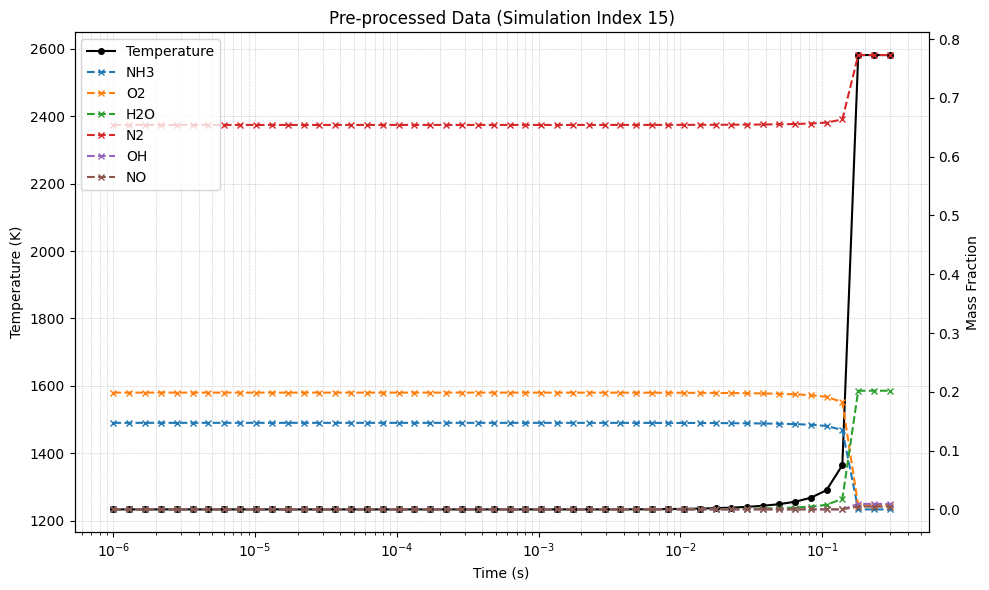

In [4]:
# Visualise the training data saved in training_data.npz

# --- Configuration ---
NPZ_FILE = 'training_data.npz'
PARAMS_FILE = 'normalization_params.json'

# 1. Pick which simulation to plot (e.g., 0 is the first one, 1 is the second, etc.)
SIMULATION_INDEX_TO_PLOT = 15

# 2. List the species you want to see
SPECIES_TO_PLOT = [
    'NH3',   # Fuel
    'O2',    # Oxidizer
    'H2O',   # Product
    'N2',    # Product
    'OH',    # Key radical
    'NO'     # Key nitrogen species
]
# ---------------------

# --- 1. Load the Data ---
try:
    data = np.load(NPZ_FILE)
    # trajectories shape is (num_simulations, num_timesteps, num_features)
    # times shape is (num_timesteps,)
    trajectories = data['trajectories']
    times = data['times']
    
    with open(PARAMS_FILE, 'r') as f:
        norm_params = json.load(f)
    mins = norm_params['mins']
    maxs = norm_params['maxs']
    
except FileNotFoundError as e:
    print(f"Error: Missing file. Make sure '{NPZ_FILE}' and '{PARAMS_FILE}' are in the same folder.")
    print(e)
    raise

# Get the feature names in the correct order
# The order is the same as in the normalization_params.json
feature_names = list(mins.keys())

# --- 2. Select and Denormalize Data ---
if SIMULATION_INDEX_TO_PLOT >= len(trajectories):
    print(f"Error: SIMULATION_INDEX_TO_PLOT is {SIMULATION_INDEX_TO_PLOT}, "
          f"but there are only {len(trajectories)} simulations.")
    raise IndexError("Index out of bounds.")
    
# Get the single, normalized trajectory
normalized_trajectory = trajectories[SIMULATION_INDEX_TO_PLOT] # Shape: (50, n_features)

# Create a DataFrame for easy handling
df_normalized = pd.DataFrame(normalized_trajectory, columns=feature_names)

# Create an empty DataFrame for the denormalized data
df_denormalized = pd.DataFrame()

# Denormalize using the formula: value = (normalized_value * (max - min)) + min
epsilon = 1e-12
for col in feature_names:
    df_denormalized[col] = (df_normalized[col] * (maxs[col] - mins[col] + epsilon)) + mins[col]

# Add the time column
df_denormalized['Time (s)'] = times

# --- 3. Create the Plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature on the primary (left) y-axis
color = 'black'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(df_denormalized['Time (s)'], df_denormalized['Temperature (K)'], 
         color=color, label='Temperature', marker='o', markersize=4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(which='both', linestyle=':', linewidth=0.5)

# Set the x-axis to a log scale
ax1.set_xscale('log')

# Create a secondary (right) y-axis for mass fractions
ax2 = ax1.twinx()
ax2.set_ylabel('Mass Fraction')

# Plot all the species on the secondary y-axis
for species in SPECIES_TO_PLOT:
    if species in df_denormalized.columns:
        ax2.plot(df_denormalized['Time (s)'], df_denormalized[species], 
                 label=species, marker='x', markersize=4, linestyle='--')
    else:
        print(f"Warning: Species '{species}' not found in data, skipping.")

# --- Create a Combined Legend ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Pre-processed Data (Simulation Index {SIMULATION_INDEX_TO_PLOT})')
fig.tight_layout()
plt.show()